<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-and-Data-loading" data-toc-modified-id="Imports-and-Data-loading-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports and Data loading</a></span></li><li><span><a href="#Result-loader" data-toc-modified-id="Result-loader-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Result loader</a></span></li><li><span><a href="#Seaborn-Style" data-toc-modified-id="Seaborn-Style-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Seaborn Style</a></span></li><li><span><a href="#Plotting-Function" data-toc-modified-id="Plotting-Function-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Plotting Function</a></span></li></ul></li><li><span><a href="#Profit-comparison" data-toc-modified-id="Profit-comparison-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Profit comparison</a></span></li><li><span><a href="#Learning-Comparison" data-toc-modified-id="Learning-Comparison-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Learning Comparison</a></span></li><li><span><a href="#Sensivity-Analysis:-Prediction-Accuracy" data-toc-modified-id="Sensivity-Analysis:-Prediction-Accuracy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sensivity Analysis: Prediction Accuracy</a></span></li></ul></div>

## Imports and Data loading

In [1]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evsim.data import load

## Result loader

In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)

start = "2016-06-01"
end = "2018-01-01"

def read_results(path):
    df = pd.read_csv(path)
    
    df["profit_eur"] = df["profit_eur"] - df["lost_rentals_eur"]
    df["charged_vpp_kwh"] = df["charged_vpp_kwh"] / 1000
    
    df["timestamp"] = df["timestamp"].apply(lambda x : datetime.fromtimestamp(x))
    df = df.set_index("timestamp") 
    df = df[start:end]
    return df

## Seaborn Style

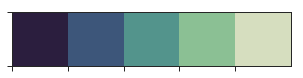

In [12]:
sns.set(rc={'figure.figsize':(10,6)})

sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.5, "lines.markersize": 7})

sns.set_style("white")
sns.set_style("ticks")

palette = sns.cubehelix_palette(5, start=.5, rot=-.75, reverse=True)
sns.set_palette(palette)

sns.palplot(palette)

## Plotting Function

In [14]:
def result_comp(dfs, names, a, y_col="profit_eur", y_name="Gross profit increase [EUR]"):
    df_results = pd.DataFrame(columns=["timestamp", "Strategy", y_name])
    for df, name in zip(dfs, names):
        
        df = df.groupby(pd.Grouper(freq="M")).sum()
        df[y_name] = df[y_col].cumsum()
        df = df.reset_index()
        df["Strategy"] = name
        df = df[["timestamp", "Strategy", y_name]]
        df_results = df_results.append(df)

    
    ax = sns.lineplot(x="timestamp", y=y_name,
                      hue="Strategy", style="Strategy",
                      markers=True, dashes=True, ci="sd", data=df_results, ax=a)

    ax.set(xlabel="");

# Profit comparison

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

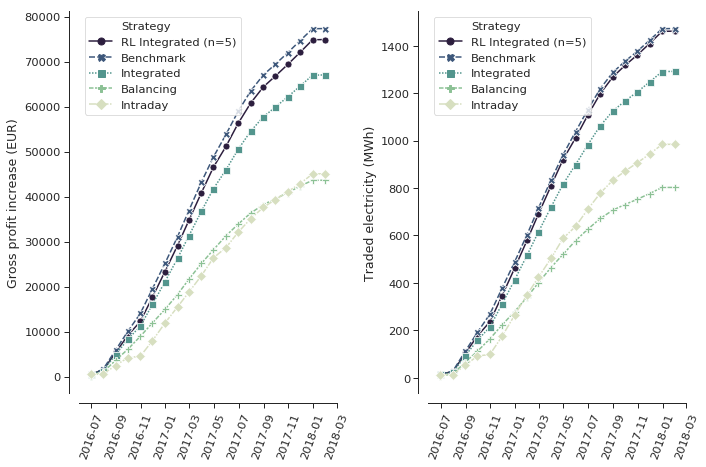

In [15]:
df_bench = read_results("../results/integrated-benchmark-acc-1.csv")
df_int = read_results("../results/integrated-risk-averse.csv")
df_rl1 = read_results("../results/accuracy/DDDQN-70-90_result.csv")
df_bal = df = read_results("../results/balancing-risk-averse.csv")
df_intr = df = read_results("../results/intraday-risk-averse.csv")

f, axs = plt.subplots(1, 2)
y_cols=["profit_eur", "charged_vpp_kwh"]
y_names=["Gross profit increase (EUR)", "Traded electricity (MWh)"]

for ax, y_col, y_name in zip(axs, y_cols, y_names):
    result_comp(
        [
            df_rl1,
            df_bench,
            df_int,
            df_bal,
            df_intr,
        ],
        [
            "RL Integrated (n=5)",
            "Benchmark",
            "Integrated",
            "Balancing",
            "Intraday",
        ],
        ax, y_col, y_name
    )
    
f.tight_layout()
sns.despine(offset=10)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=70)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=70)

# Learning Comparison

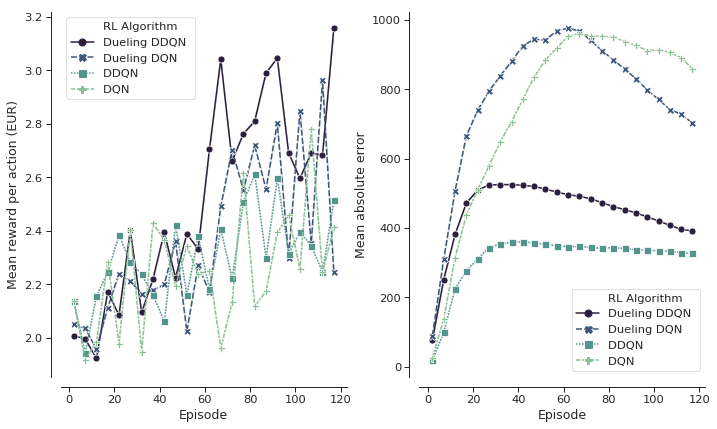

In [7]:
from pathlib import Path

def labels(key):
    label = key.strip("nb_").replace("_", " ").capitalize()
    label = label + " per action" if "Mean reward" in label else label
    label = label + " (EUR)" if "reward" in label else label
    return label

def algo_names(file):
    name = Path(file)
    name = name.stem
    name = ''.join([i for i in name if not i.isdigit()])
    name = name.replace("_", " ").upper()
    name = name.replace("DUEL", "Dueling")
    return name

def visualize_log(files, keys, grouper=10):
    df_learning = pd.DataFrame()
    
    
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
        if 'episode' not in data:
            raise ValueError('Log file "{}" does not contain the "episode" key.'.format(file))
        
        
        df = pd.DataFrame(data)
        df["mean_reward"] = df["episode_reward"] / df["nb_episode_steps"]
        df = df.groupby(df.index // grouper).mean()
        
        df["RL Algorithm"] = algo_names(file)
        df_learning = df_learning.append(df)
        
    
    df_learning = df_learning[df_learning["episode"] < 120]

    f, axs = plt.subplots(1, len(keys))
    for idx, key in enumerate(keys):
        g = sns.lineplot(x="episode", y=key, 
                     style="RL Algorithm", hue="RL Algorithm",
                     dashes=True, markers=True, ci=0,
                     data=df_learning, ax=axs[idx])
        
        ylabel=labels(key)
        g.set(xlabel='Episode', ylabel=ylabel)    
        
        #plt.xticks(np.arange(0, df_learning["episode"].max() + 1, 30));  
        
    plt.tight_layout()
    plt.tight_layout()
    sns.despine(offset=10)


logs = [
        "../results/rl/duel_ddqn_1.json", 
        "../results/rl/duel_ddqn_2.json", 
        "../results/rl/duel_ddqn_3.json", 
        "../results/rl/duel_dqn_1.json", 
        "../results/rl/duel_dqn_2.json", 
        "../results/rl/duel_dqn_3.json", 
        "../results/rl/ddqn_1.json", 
        "../results/rl/ddqn_2.json", 
        "../results/rl/ddqn_3.json", 
        "../results/rl/dqn_1.json",
        "../results/rl/dqn_2.json",
        "../results/rl/dqn_3.json",
       ]
cols = ["mean_reward", "mean_absolute_error"]
visualize_log(logs, cols, grouper=5)

# Sensivity Analysis: Prediction Accuracy

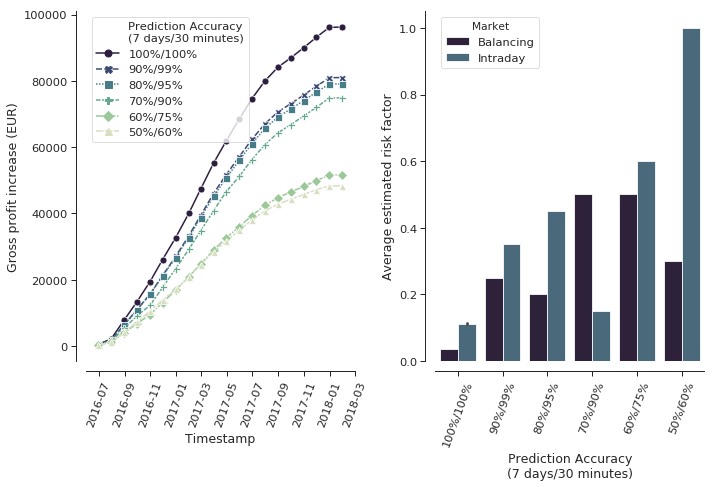

In [8]:
from pathlib import Path

def labels(key):
    label = key.strip("nb_").replace("_", " ").title()
    label = "Gross profit increase (EUR)" if "Profit" in label else label
    return label

def accuracy(file):
    name = Path(file)
    name = name.stem
    if "benchmark" in name:
        return "Full information"
    
    name = ''.join([i for i in name if not i.isalpha()])
    name = name[1:-1]
    name = name.replace("-", "%/")
    name = name + "%"
    return name


def visualize_results(files, keys, grouper=10):
    df_accuracy = pd.DataFrame()
    df_risks = pd.DataFrame()
    
    groups="Prediction Accuracy\n(7 days/30 minutes)"
    
    for file in files:
        df = read_results(file)
        df[groups] = accuracy(file)
        df_risks = df_risks.append(df)
        
        
        df = df.groupby(pd.Grouper(freq="M")).agg({
                                    'risk_bal': np.mean,
                                    'risk_intr': np.mean,
                                    'profit_eur': np.sum,
                                    'imbalance_kwh': np.sum,
                                    'lost_rentals_eur': np.sum,
                                    'charged_vpp_kwh': np.sum,
                                    groups : "first"
                                    }) 
        df = df.reset_index()
        df["profit_eur"] = df["profit_eur"].cumsum()
        df_accuracy = df_accuracy.append(df)
        
        
        
    f, axs = plt.subplots(1, 2)
    
    # Profits evolution
    y = "profit_eur"
    sns.set_palette(sns.cubehelix_palette(6, start=.5, rot=-.75, reverse=True))
    g = sns.lineplot(x="timestamp", y=y, 
                 style=groups, hue=groups,
                 dashes=True, markers=True, ci=0,
                 data=df_accuracy,
                 ax=axs[0])
    g.set(xlabel='Timestamp', ylabel=labels(y))    
        
    # Risk barplot    
    y = "profit"
    var_name = "Market"
    df_risk = df_risks[[groups, "risk_bal", "risk_intr"]]
    df_risk.columns = [groups, "Balancing", "Intraday"]
    df_risk = pd.melt(df_risk, id_vars=groups, var_name=var_name, value_name=y)

    sns.set_palette(sns.cubehelix_palette(4, start=.5, rot=-.75, reverse=True))
    g = sns.barplot(x=groups, y=y, data=df_risk, hue=var_name, ax=axs[1])
    g.set(ylabel="Average estimated risk factor")    
        

    plt.tight_layout()
    sns.despine(offset=10)
    
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=70)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=70)

results = [
        "../results/accuracy/DDDQN-100-100_result.csv", 
        "../results/accuracy/DDDQN-90-99_result.csv", 
        "../results/accuracy/DDDQN-80-95_result.csv", 
        "../results/accuracy/DDDQN-70-90_result.csv", 
        "../results/accuracy/DDDQN-60-75_result.csv", 
        "../results/accuracy/DDDQN-50-60_result.csv", 
       ]
cols = ["profit_eur", "risk"]
visualize_results(results, cols)